# Stat209 HW3

Seokjun Choi

## Problem 3

*Code blocks are Python scripts of this problem.*

*Executable stand-alone Python script: https://github.com/letsjdosth/GLM/blob/main/hw3q3.py*

*This code depends on third-party packages*
- numpy
- matplotlib
- scipy

and another python module that I implemented,
- MCMC_Core: *https://github.com/letsjdosth/GLM/blob/main/pyBayes/MCMC_Core.py* (Special thanks: Juhee & Richard, in STAT206B and STAT207)

*All scripts are tested in Python 3.10.5 64-bit, in Windows 10.*


I will use the same notation given in the problem.


Please see the attached note for model settings and calculation results of posterior distributions.
In this document, I will use its notations and results without any additional explanation.

### Models

Please see the note attached.
I will implement the non-canonical link (log-link) models I write on the note, for both gamma and inverse gaussian.

The below block is just for setting. (for similar works for problem 2's first block.)

In [1]:
# HW3Q3

from random import seed, normalvariate, gammavariate
from math import exp, log, lgamma
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import invgauss

from pyBayes import MCMC_Core

seed(20221106)


# Data set for homework 3, problem 3
# response y: machine tool failure time (minutes)
# covariate x: cutting speed (fpm)

failure_time = (70,29,60,28,64,32,44,24,35,31,38,35,52,23,40,28,46,33,46,27,37,34,41,28)
cutting_speed = (340,570,340,570,340,570,340,570,440,440,440,440,305,635,440,440,440,440,305,635,440,440,440,440)

x_y = [(x,y) for x,y in zip(cutting_speed, failure_time)]
# print(x_y)



# all MCMC settings
def symmetric_proposal_placeholder(from_smpl, to_smpl):
    #for log_proposal
    return 0

def normal_proposal_sampler(from_smpl, proposal_sigma_vec):
    return [normalvariate(x, proposal_sigma_vec[i]) for i,x in enumerate(from_smpl)]

def gamma_loglink_posterior(beta_lambda, data, sigma1, sigma2, sigma_lambda):
    beta1 = beta_lambda[0]
    beta2 = beta_lambda[1]
    lam = beta_lambda[2]
    v = exp(lam)

    log_post = 0
    for (x, y) in data:
        nu = beta1 + beta2*x
        try:
            log_post += (-lgamma(v) + v*log(v) -v*nu + (v-1)*log(y) - v*y/exp(nu))
        except ZeroDivisionError:
            raise ZeroDivisionError(beta1, beta2, x, nu, exp(nu))

    log_post += (-0.5*beta1**2/sigma1**2 - 0.5*beta2**2/sigma2**2 -0.5*lam**2/sigma_lambda**2)
    return log_post

def inv_gaussian_loglink_posterior(beta_lambda, data, sigma1, sigma2, sigma_lambda):
    beta1 = beta_lambda[0]
    beta2 = beta_lambda[1]
    lam = beta_lambda[2]
    phi = exp(lam)

    log_post = 0
    for (x, y) in data:
        nu = beta1 + beta2*x
        log_post += (-0.5*log(phi) - 1.5*log(y) - (y - exp(nu))**2 / (2*phi*y*exp(2*nu)))
    log_post += (-0.5*beta1**2/sigma1**2 - 0.5*beta2**2/sigma2**2 - 0.5*lam**2/sigma_lambda**2)
    return log_post

# utility
def mu_plot(posterior_samples, link_func): #depend on x_y
    x_grid = np.arange(300, 650, 1)
    lwr = []
    med = []
    upr = []
    avg = []
    for x in x_grid:
        mu_samples_at_x = [link_func(x, params) for params in posterior_samples]
        lwr.append(float(np.quantile(mu_samples_at_x, 0.025)))
        med.append(float(np.quantile(mu_samples_at_x, 0.5)))
        upr.append(float(np.quantile(mu_samples_at_x, 0.975)))
        avg.append(float(np.mean(mu_samples_at_x)))

    plt.plot(x_grid, avg, color="black")
    plt.plot(x_grid, med, color="red")
    plt.plot(x_grid, lwr, color="grey")
    plt.plot(x_grid, upr, color="grey")
    plt.scatter([x[0] for x in x_y], [x[1] for x in x_y], marker="o")
    plt.show()

def bayesian_residual_plot(posterior_samples, link_func): #depend on x_y
    x_grid = [x[0] for x in x_y]
    boxplot_frame = []
    for (x, y) in x_y:
        res_samples_at_x = [link_func(x, params)-y for params in posterior_samples]
        boxplot_frame.append(res_samples_at_x)

    plt.boxplot(np.transpose(boxplot_frame), labels=x_grid)
    plt.axhline(0)
    plt.show()

def loss_L_measure(posterior_samples, predictive_generator, k): #depend on x_y
    loss = 0
    for (x, y) in x_y:
        y_predictive_samples_at_x = [predictive_generator(x, param) for param in posterior_samples]
        predictive_var_at_x = np.var(y_predictive_samples_at_x)
        predictive_mean_at_x = np.mean(y_predictive_samples_at_x)
        loss += (predictive_var_at_x + (k/(k+1))*(y-predictive_mean_at_x)**2)
    return loss

def get_posterior_samples_for_mu(x, posterior_samples, link_func):
    return [link_func(x, params) for params in posterior_samples]

def gamma_predictive_generator(x, param):
    #param: [beta1, beta2, lambda]
    shape = exp(param[2]) #v
    rate = shape/exp(param[0]+param[1]*x)
    return gammavariate(shape, 1/rate)

def inv_gaussian_predictive_generator(x, param): #need to check. is it right?
    #param: [beta1, beta2, lambda]
    mu = exp(param[0]+param[1]*x)
    phi = exp(param[2])
    return invgauss.rvs(mu=mu*phi, scale=1/phi)
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgauss.html

def log_link(x, params):
    return exp(params[0]+params[1]*x)



### Gamma model fit

Here, following the same notation of the note, $\lambda = log(\nu)$.
I use the prior, $[\beta_1, \beta_2, \lambda] \sim N_3([0,0,0], diag(50^2, 50^2, 50^2))$ that is quite vague.
It may not be vague in the view of $\nu$, though.

estimated running time:  0.0 min  8.05521011352539 sec
iteration 20000 / 200000
iteration 40000 / 200000
iteration 60000 / 200000
iteration 80000 / 200000
iteration 100000 / 200000
iteration 120000 / 200000
iteration 140000 / 200000
iteration 160000 / 200000
iteration 180000 / 200000
iteration 200000 / 200000  done! (elapsed time for execution:  0.0 min  9.126839876174927 sec)
acceptance rate:  0.0089


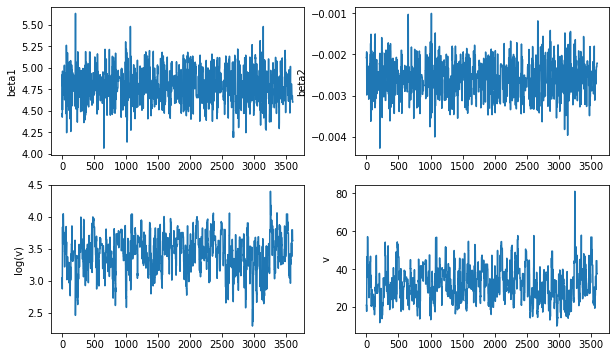

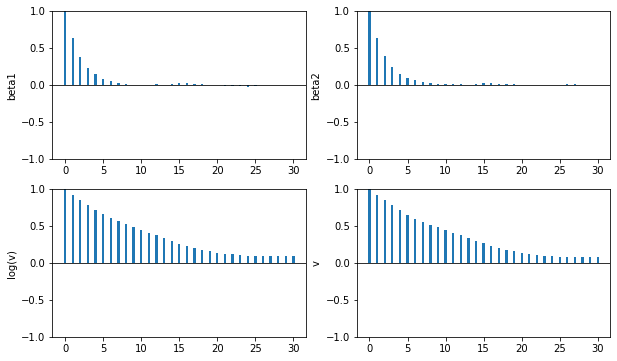

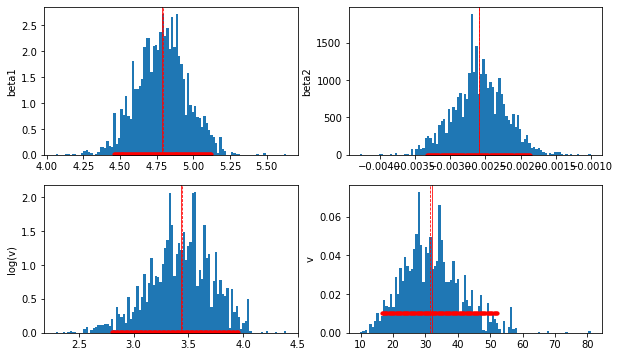

param 		 mean 	 var 	 95%CI
beta1 		 4.785 	 0.03 	 [4.457, 5.12]
beta2 		 -0.003 	 0.0 	 [-0.003, -0.002]
log(v) 		 3.43 	 0.085 	 [2.802, 3.954]
v 		 32.173 	 83.574 	 [16.478, 52.159]


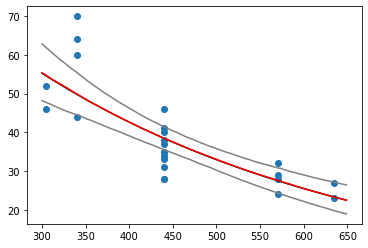

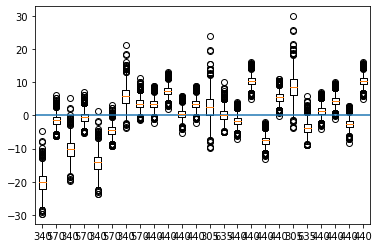

L, at k=2 : 2236.2657701169755
L, at k=10 : 2530.429254752432


In [2]:

gamma_log_initial = [0,0,0]
gamma_log_inst = MCMC_Core.MCMC_MH(
                partial(gamma_loglink_posterior, data=x_y, sigma1=50, sigma2=50, sigma_lambda=50),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[0.5, 0.005, 0.2]),
                gamma_log_initial)
gamma_log_inst.generate_samples(200000, print_iter_cycle=20000)

gamma_log_samples_appended = [smpl + [exp(smpl[2])] for smpl in gamma_log_inst.MC_sample]

gamma_log_diag = MCMC_Core.MCMC_Diag()
gamma_log_diag.set_mc_samples_from_list(gamma_log_samples_appended)
gamma_log_diag.set_variable_names(["beta1", "beta2", "log(v)", "v"])
gamma_log_diag.burnin(20000)
gamma_log_diag.thinning(50)
gamma_log_diag.show_traceplot((2,2))
gamma_log_diag.show_acf(30, (2,2))
gamma_log_diag.show_hist((2,2))
gamma_log_diag.print_summaries(3)


mu_plot(gamma_log_diag.MC_sample, log_link)
bayesian_residual_plot(gamma_log_diag.MC_sample, log_link)
print("L, at k=2 :", loss_L_measure(gamma_log_diag.MC_sample, gamma_predictive_generator, 2)) 
print("L, at k=10 :", loss_L_measure(gamma_log_diag.MC_sample, gamma_predictive_generator, 10)) 
#2236.2657701169755 at k=2
#2548.666959908084 at k=10

Plots are:
- traceplot of all parameters (please see y-label) of MCMC chain
- ACF plots of all parameters (please see y-label) in the generated MCMC samples
- Histograms (blue), posterior mean(red vertical line), median (red dotted line), and 95% centered posterior credible interval (red horizontal line) for all parameters (please see y-label)
- $\mu$ verses cutting_speed plot, indicating posterior means (red curve), 95% centered posterior credible intervals (two gray curves), and observed $y$ s(blue dots)
- Bayesian residual box-plot at each data point, using $\mu$ samples (Caution: the horizontal axis is sorted by the data index $i$, not x value itself.)

Note that I ran the MCMC chain with $\beta_1, \beta_2, \lambda$.
Samples of $\nu$ are converted from $\lambda$ samples.

The table output in the middle is the posterior summary (One more time, sorry for the bad tab setting to print python string. The column doesn't fit well.)
The last line output is the 'quadratic L measure' of the model, using posterior predictive samples, with $k=2$ and $k=10$.

The MCMC chain seems to converge well, even if the ACF of $\lambda$ decays slowly.

On the fitted $\mu$ plot, the curve of the posterior mean(red) seems good. However, a wider 95% posterior interval of $ \mu $ (grey curves) would be better.
At $x=340$ and $x=440$, many observed $y$ values fell outside of the interval.
We can conclude a similar result using the Bayesian residual plot. It would be better if the whiskers got longer.

Later, I will compare the calculated L values with the inverse gaussian fit.

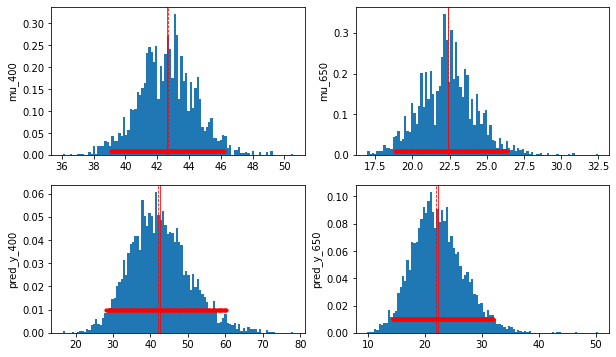

param 		 mean 	 var 	 95%CI
mu_400 		 42.626 	 3.168 	 [39.107, 46.224]
mu_650 		 22.403 	 3.539 	 [18.837, 26.35]
pred_y_400 		 42.516 	 65.49 	 [28.227, 60.174]
pred_y_650 		 22.339 	 20.562 	 [14.34, 32.006]


In [3]:
gamma_mu_at_400 = get_posterior_samples_for_mu(400, gamma_log_diag.MC_sample, log_link)
gamma_mu_at_650 = get_posterior_samples_for_mu(650, gamma_log_diag.MC_sample, log_link)
gamma_pred_y_at_400 = [gamma_predictive_generator(400, s) for s in gamma_log_diag.MC_sample]
gamma_pred_y_at_650 = [gamma_predictive_generator(650, s) for s in gamma_log_diag.MC_sample]
gamma_log_diag2 = MCMC_Core.MCMC_Diag()
gamma_log_diag2.set_mc_samples_from_list([(a,b,c,d) for (a,b,c,d) in zip(gamma_mu_at_400, gamma_mu_at_650, gamma_pred_y_at_400, gamma_pred_y_at_650)])
gamma_log_diag2.set_variable_names(["mu_400", "mu_650", "pred_y_400", "pred_y_650"])
gamma_log_diag2.show_hist((2,2))
gamma_log_diag2.print_summaries(3)

The above plots are,
- top left: $\mu$'s posterior distribution at $x=400$
- top right: $\mu$'s posterior distribution at $x=650$
- bottom left: $y$'s posterior predictive distribution at $x=400$
- bottom right: $y$'s posterior predictive distribution at $x=650$
with histograms (blue), posterior mean(red vertical line), median (red dotted line), and 95% centered posterior credible interval (red horizontal line) for all parameters (please see y-label).

The table shows summary values.

### Inverse Gaussian model fit

Now, I use the prior $[\beta_1, \beta_2, \lambda] \sim N([0,0,0], [50^2, 50^2, 50^2])$, where $\lambda = log(\phi)$.

estimated running time:  0.0 min  10.898113250732422 sec
iteration 20000 / 200000
iteration 40000 / 200000
iteration 60000 / 200000
iteration 80000 / 200000
iteration 100000 / 200000
iteration 120000 / 200000
iteration 140000 / 200000
iteration 160000 / 200000
iteration 180000 / 200000
iteration 200000 / 200000  done! (elapsed time for execution:  0.0 min  10.779861211776733 sec)
acceptance rate:  0.0081


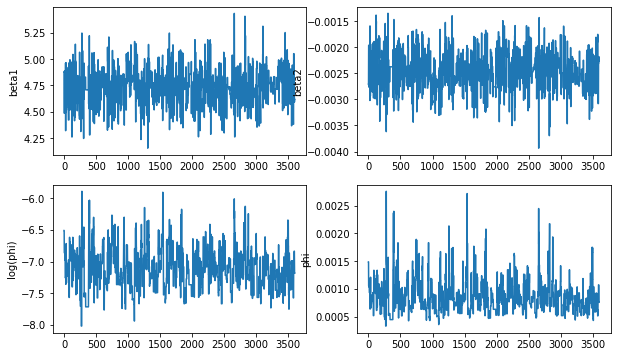

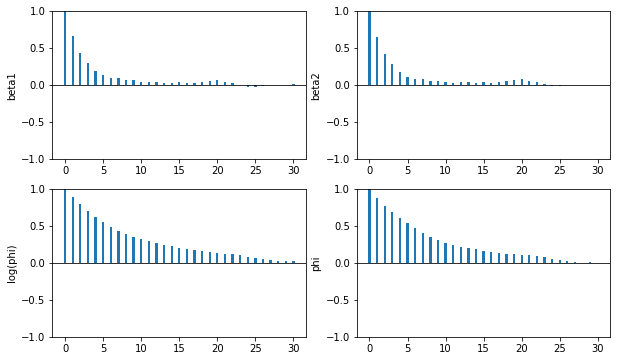

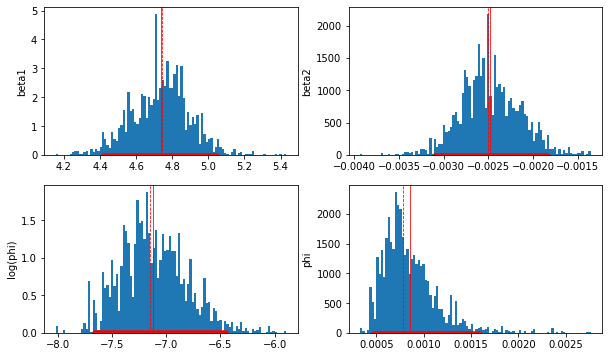

param 		 mean 	 var 	 95%CI
beta1 		 4.737 	 0.026 	 [4.414, 5.05]
beta2 		 -0.002 	 0.0 	 [-0.003, -0.002]
log(phi) 		 -7.117 	 0.097 	 [-7.667, -6.45]
phi 		 0.001 	 0.0 	 [0.0, 0.002]


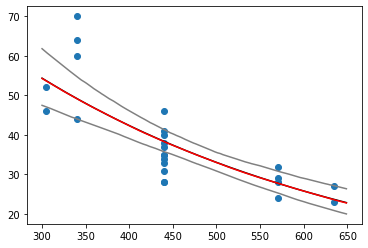

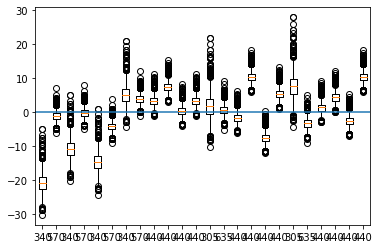

L, at k=2 : 2335.9837324413934
L, at k=10 : 2648.0565187397456


In [4]:

inv_gaussian_log_initial = [0,0,0]
inv_gaussian_log_inst = MCMC_Core.MCMC_MH(
                partial(inv_gaussian_loglink_posterior, data=x_y, sigma1=50, sigma2=50, sigma_lambda=50),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[0.5, 0.005, 0.3]),
                inv_gaussian_log_initial)
inv_gaussian_log_inst.generate_samples(200000, print_iter_cycle=20000)

inv_gaussian_log_samples_appended = [smpl + [exp(smpl[2])] for smpl in inv_gaussian_log_inst.MC_sample]

inv_gaussian_log_diag = MCMC_Core.MCMC_Diag()
inv_gaussian_log_diag.set_mc_samples_from_list(inv_gaussian_log_samples_appended)
inv_gaussian_log_diag.set_variable_names(["beta1", "beta2", "log(phi)", "phi"])
inv_gaussian_log_diag.burnin(20000)
inv_gaussian_log_diag.thinning(50)
inv_gaussian_log_diag.show_traceplot((2,2))
inv_gaussian_log_diag.show_acf(30, (2,2))
inv_gaussian_log_diag.show_hist((2,2))
inv_gaussian_log_diag.print_summaries(3)

mu_plot(inv_gaussian_log_diag.MC_sample, log_link)
bayesian_residual_plot(inv_gaussian_log_diag.MC_sample, log_link)
print("L, at k=2 :", loss_L_measure(inv_gaussian_log_diag.MC_sample, inv_gaussian_predictive_generator, 2))
print("L, at k=10 :", loss_L_measure(inv_gaussian_log_diag.MC_sample, inv_gaussian_predictive_generator, 10))
#2279.2581621040554 at k=2
#2586.9292392851125 at k=10


MCMC convergence seems good.

Because the two models have a totally different assumptions, comparing $\beta_1, \beta_2$ values are meaningless. So I skip it.

With my eyes, I cannot find significant differences between gamma fit and inverse gaussian fit from the $\mu$ plot and the residual plot.
However, the calculated quadratic loss measures L at both $k=2$ and $k=10$ tell us that the gamma fit is better.
Yes, the gamma model is slightly better than inverse gaussian model if we accept the 'L' criterion. :D

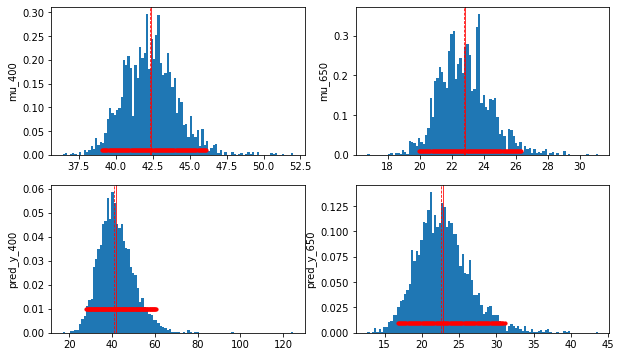

param 		 mean 	 var 	 95%CI
mu_400 		 42.358 	 3.338 	 [39.084, 46.098]
mu_650 		 22.83 	 2.547 	 [19.972, 26.334]
pred_y_400 		 42.07 	 69.375 	 [28.09, 60.509]
pred_y_650 		 22.888 	 13.307 	 [16.781, 31.093]


In [5]:
inv_gaussian_mu_at_400 = get_posterior_samples_for_mu(400, inv_gaussian_log_diag.MC_sample, log_link)
inv_gaussian_mu_at_650 = get_posterior_samples_for_mu(650, inv_gaussian_log_diag.MC_sample, log_link)
inv_gaussian_pred_y_at_400 = [inv_gaussian_predictive_generator(400, s) for s in inv_gaussian_log_diag.MC_sample]
inv_gaussian_pred_y_at_650 = [inv_gaussian_predictive_generator(650, s) for s in inv_gaussian_log_diag.MC_sample]
inv_gaussian_log_diag2 = MCMC_Core.MCMC_Diag()
inv_gaussian_log_diag2.set_mc_samples_from_list([(a,b,c,d) for (a,b,c,d) in zip(inv_gaussian_mu_at_400, inv_gaussian_mu_at_650, inv_gaussian_pred_y_at_400, inv_gaussian_pred_y_at_650)])
inv_gaussian_log_diag2.set_variable_names(["mu_400", "mu_650", "pred_y_400", "pred_y_650"])
inv_gaussian_log_diag2.show_hist((2,2))
inv_gaussian_log_diag2.print_summaries(3)


Like the gamma model's output, the above plots are, from the inverse gaussian model,
- top left: $\mu$'s posterior distribution at $x=400$
- top right: $\mu$'s posterior distribution at $x=650$
- bottom left: $y$'s posterior predictive distribution at $x=400$
- bottom right: $y$'s posterior predictive distribution at $x=650$
with histograms (blue), posterior mean(red vertical line), median (red dotted line), and 95% centered posterior credible interval (red horizontal line) for all parameters (please see y-label).

The table shows summary values.

I can't find significant differences between results of gamma model's and of inverse gaussian model's.
Their tail behaviors seem different, but I'm not sure. (Both distributions have exponential decay rates at their tails, aren't they?)